# Multi-class Dog Breed Classification
Multiclass Dog Breed classification model build with TensorFlow and TensorFlow Hub

## 1. Problem
Given an image of a dog, asked to identify its breed.

## 2. Data
Data used is taken from Stanford University Dogs Dataset http://vision.stanford.edu/aditya86/ImageNetDogs/

## 3. Evaluation
The resultant model will be evaluated based on the Multi-class Log Loss.

## 4. Features
- Unstructured data (images)
- 120 Categories (dog breeds)
- Total of 20580 unique images.
- Approximately 150 images per breed.

# First, We Need to Prepare Libraries

In [1]:
#Import libraries
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import random
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

#Check whether theres GPU available
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.6.4
TF Hub version: 0.12.0
GPU available


2022-08-13 08:56:48.358697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-13 08:56:48.468275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-13 08:56:48.469126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Data Preparation
## Retrieve the image's respective filename and label

In [20]:
filenames = []

for folders in os.listdir("../input/stanford-dogs-dataset/images/Images"):
    for files in os.listdir(f"../input/stanford-dogs-dataset/images/Images/{folders}"):
        filenames.append(f"../input/stanford-dogs-dataset/images/Images/{folders}/{files}")
    
# Converts filename to ndarray, 
filenames = np.array(filenames)
# then Shuffle for balanced batches
np.random.shuffle(filenames)
# Obtain labels based on filename
labels = np.array(["".join(name.split('/')[-2].split("-")[1:]) for name in filenames])

## Retrieve the classes (unique dog breeds)

In [23]:
# Create array of unique breeds
unique_breeds = np.unique(labels)

print(f"LABEL SIZE = {len(labels)}")
print(labels[:5])
print(f"\nFILENAMES SIZE = {len(filenames)}")
print(filenames[:5])
print(f"\nUNIQUE BREED SIZE = {len(unique_breeds)}")
print(unique_breeds[:10])

LABEL SIZE = 20580
['Old_English_sheepdog' 'Lakeland_terrier' 'English_setter'
 'Staffordshire_bullterrier' 'Pekinese']

FILENAMES SIZE = 20580
['../input/stanford-dogs-dataset/images/Images/n02105641-Old_English_sheepdog/n02105641_5982.jpg'
 '../input/stanford-dogs-dataset/images/Images/n02095570-Lakeland_terrier/n02095570_5641.jpg'
 '../input/stanford-dogs-dataset/images/Images/n02100735-English_setter/n02100735_4508.jpg'
 '../input/stanford-dogs-dataset/images/Images/n02093256-Staffordshire_bullterrier/n02093256_567.jpg'
 '../input/stanford-dogs-dataset/images/Images/n02086079-Pekinese/n02086079_499.jpg']

UNIQUE BREED SIZE = 120
['Afghan_hound' 'African_hunting_dog' 'Airedale'
 'American_Staffordshire_terrier' 'Appenzeller' 'Australian_terrier'
 'Bedlington_terrier' 'Bernese_mountain_dog' 'Blenheim_spaniel'
 'Border_collie']


## Convert labels into an array of boolean value 0s and 1s (one-hot encoding)

In [25]:
boolean_labels = np.array([label == unique_breeds for label in labels]).astype(int)
boolean_labels.shape, boolean_labels[0]

((20580, 120),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

## Let's convert all that steps into a function

In [31]:
def retrieve_data_from_path(path="../input/stanford-dogs-dataset/images/Images"):
    """
    Reads a directory and retrieves all the image file path, and their respective labels.
    Returns x, y, classes.
    x = filenames
    y = one-hot-encoded labels
    classes = classification classes
    """
    
    filenames = []

    for folders in os.listdir(path):
        for files in os.listdir(f"{path}/{folders}"):
            filenames.append(f"{path}/{folders}/{files}")

    filenames = np.array(filenames)
    np.random.shuffle(filenames)
    labels = np.array(["".join(name.split('/')[-2].split("-")[1:]) for name in filenames])
    unique_breeds = np.unique(labels)
    boolean_labels = np.array([label == unique_breeds for label in labels]).astype(int)
    return filenames, boolean_labels, unique_breeds

## With that, the x and y data are ready

In [32]:
x, y, unique_breeds = retrieve_data_from_path("../input/stanford-dogs-dataset/images/Images")
x[:5], y[:5]

(array(['../input/stanford-dogs-dataset/images/Images/n02096177-cairn/n02096177_5117.jpg',
        '../input/stanford-dogs-dataset/images/Images/n02085620-Chihuahua/n02085620_2706.jpg',
        '../input/stanford-dogs-dataset/images/Images/n02096177-cairn/n02096177_1889.jpg',
        '../input/stanford-dogs-dataset/images/Images/n02087394-Rhodesian_ridgeback/n02087394_3256.jpg',
        '../input/stanford-dogs-dataset/images/Images/n02105641-Old_English_sheepdog/n02105641_1618.jpg'],
       dtype='<U105'),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

# Data Preprocessing

## Generate processed tensors
Next step is to preprocess our image data into a format which can be processed and trained by TensorFlow aka tensors.

In [28]:
IMG_SIZE = 224

#Function for preprocessing
def process_image(filename, img_size=IMG_SIZE):
    """
    Takes an image filepath and turns it into a tensor.
    """
    #read image
    image = tf.io.read_file(filename)

    #turn jpeg to numerical Tensor with 3 color channels (RGB)
    image = tf.image.decode_jpeg(image, channels=3)

    #Convert colour channels values 0-255 to 0-1 values.
    #This is a normalization process to make process more efficient.
    image = tf.image.convert_image_dtype(image, tf.float32)

    #Resize to (224,224)
    image = tf.image.resize(image, size=[img_size, img_size])

    return image

In [29]:
process_image(x[0]).shape # Creates a tensor with shape 224,224, 3 for the 3 layers of color RGB

2022-08-13 09:19:09.632144: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-13 09:19:09.632791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-13 09:19:09.633703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-13 09:19:09.634393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

TensorShape([224, 224, 3])

## Configure tensors for performance (convert into tensor batches, shuffling, and prefetch)

In [30]:
def configure_tensor(ds, shuffle=False):
    if shuffle: # For train set
        ds = ds.shuffle(buffer_size=1000) # Since we already shuffled whole dataset, so we dont need the buffer size to be too large
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

## Create a function to do all the pre-processing in one go (Data Pipeline)

In [37]:
IMG_SIZE = 224
BATCH_SIZE = 32

#Image Data Pipeline Function
def image_data_pipeline(path, img_size=IMG_SIZE, batch_size=BATCH_SIZE, test_data=False, seed=42):
    """
    Reads images from path, and splits them into training and validation sets
    Create batches of data out of (image x) and (label y) pairs.
    Returns two data batches training_batch and validation_batch.

    Also accepts test data as input (no labels).
    """
    
    # Function for retrieving data
    def retrieve_data_from_path(path, test_data=False):
        filenames = []
        # Test data image retrieval (not separated per class)
        if test_data:
            for files in os.listdir(path):
                filenames.append(f"{path}/{files}")
            return np.array(filenames)
        
        # Train and val data image retrieval
        else:
            for folders in os.listdir(path):
                for files in os.listdir(f"{path}/{folders}"):
                    filenames.append(f"{path}/{folders}/{files}")
            filenames = np.array(filenames)
            np.random.shuffle(filenames)
            labels = np.array(["".join(name.split('/')[-2].split("-")[1:]) for name in filenames])
            unique_breeds = np.unique(labels)
            boolean_labels = np.array([label == unique_breeds for label in labels]).astype(int)
            return filenames, boolean_labels

    #Function for preprocessing
    def process_image(filename, img_size=IMG_SIZE):
        #read image
        image = tf.io.read_file(filename)

        #turn jpeg to numerical Tensor with 3 color channels (RGB)
        image = tf.image.decode_jpeg(image, channels=3)

        #Convert colour channels values 0-255 to 0-1 values.
        #This is a normalization process to make process more efficient.
        image = tf.image.convert_image_dtype(image, tf.float32)

        #Resize to (224,224)
        image = tf.image.resize(image, size=[img_size, img_size])

        return image
    
    # Function for data configuration (for performance) 
    def configure_tensor(ds, shuffle=False):
        if shuffle: # For train set
            ds = ds.shuffle(buffer_size=1000) 
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds
    
    # ----------------------------------------------------------------------------------
    
    # Test data pipeline
    if test_data:
        print(f"Creating test data batches... BATCH SIZE={batch_size}")
        x = retrieve_data_from_path(path, test_data=True)
        x_test = tf.data.Dataset.from_tensor_slices(x).map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        return configure_tensor(x_test)
    
    # Train and validation data pipeline
    else:
        print(f"Creating train & validation data batches... BATCH SIZE={batch_size}")
        x, y = retrieve_data_from_path(path)
        x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=seed)
        x_train = tf.data.Dataset.from_tensor_slices(x_train).map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        x_valid = tf.data.Dataset.from_tensor_slices(x_valid).map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        y_train = tf.data.Dataset.from_tensor_slices(y_train)
        y_valid = tf.data.Dataset.from_tensor_slices(y_valid)
        train_data = tf.data.Dataset.zip((x_train, y_train)) 
        valid_data = tf.data.Dataset.zip((x_valid, y_valid)) 
        return configure_tensor(train_data, shuffle=True), configure_tensor(valid_data)
    
  

## Generate Train and Validation Data for Base Training (No augmentation)

In [38]:
path = "../input/stanford-dogs-dataset/images/Images"
train_data, valid_data = image_data_pipeline(path)
train_data.element_spec, valid_data.element_spec

Creating train & validation data batches... BATCH SIZE=32


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)))

## Visualize the generated image batches

2022-08-13 07:13:39.669482: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


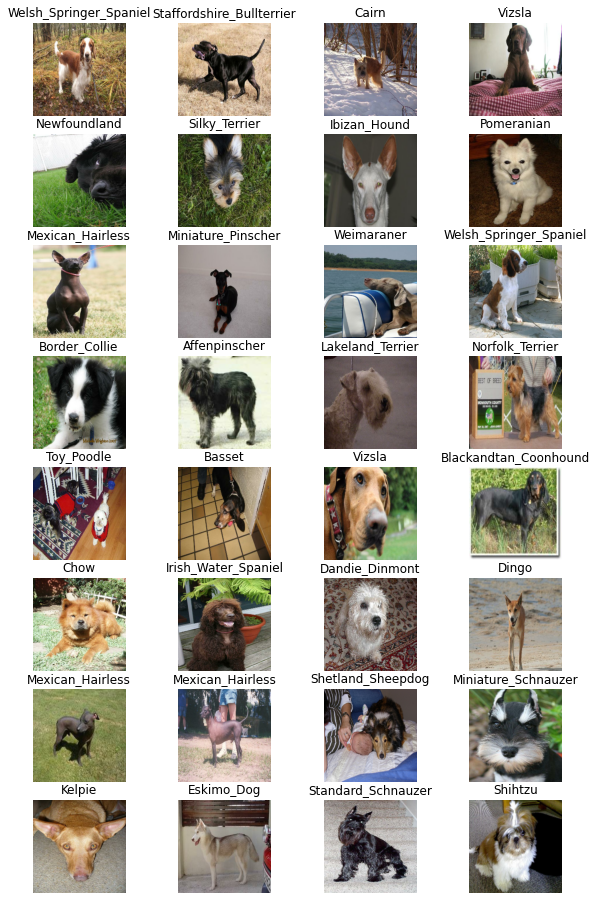

In [14]:
def show_batch(image_batch, label_batch):
  fig = plt.figure(figsize=(10,16))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(8,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(unique_breeds[label_batch[n]==1][0].title(), fontsize=12)
      plt.axis('off')
    
image_batch, label_batch = next(train_data.as_numpy_iterator())
show_batch(image_batch, label_batch)

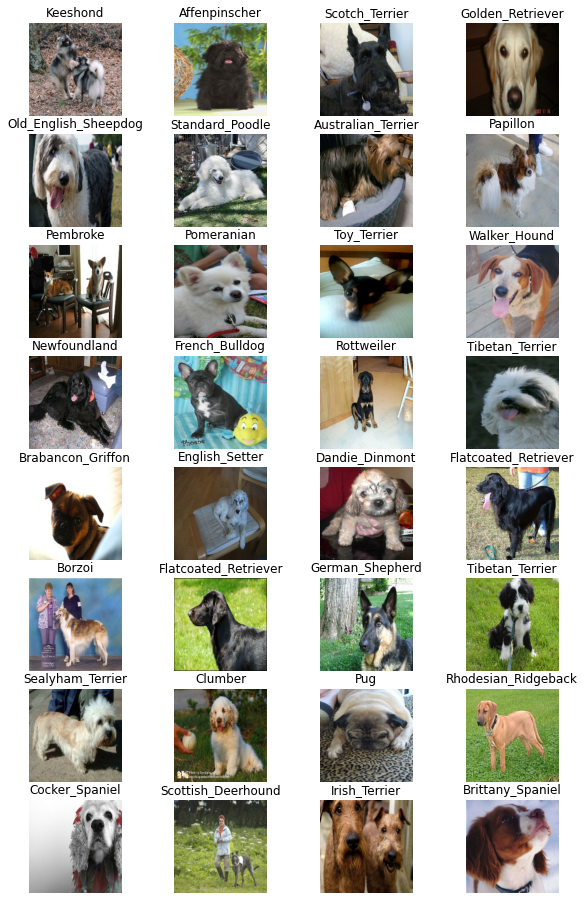

In [16]:
valid_image, valid_label = next(val_data.as_numpy_iterator())
show_batch(valid_image, valid_label)

# Building a Model !

Before we build a model, there are a few things we need to define:
* The input shape (image shape in the form of Tensors)
* The output shape (image labels in the form of Tensors)
* URL of model we want to use Transfer Learning with from TensorFlow Hub
https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5

^^ MobileNetV3 Image Classification (Size = 224x224, Depth Multiplier = 1.0)

In [17]:
#setup input shape into the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] #batch, height, width, colour channel

#setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

#setup model URL from Tensorflow HUB
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5"

Now we've got our Inputs, Outputs, and Model ready...
Lets put them together into a Keras Deep Learning Model!

Knowing this, let's create a function that:
* takes input shape, output shape, and model as parameters
* Defines the layers of KEras Model in a sequential fashion
* Compiles the model (Says it should be evaluated and improved)
* Builds model (Tell model the input shape it'll be getting)
* Return the model

All the steps can be found in https://www.tensorflow.org/guide/keras/overview

In [18]:
# Create a Function which builds a Keras Model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print(f"Building model with {MODEL_URL}")

  # Setup Model Layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (Input Layer)
    tf.keras.layers.Dense(units=output_shape, activation="softmax") # Layer 4 (Output Layer)       
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics =["accuracy"]
  )

  # Build Model
  model.build(input_shape)

  return model

In [19]:
model = create_model()
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5508713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,628,953
Trainable params: 120,240
Non-trainable params: 5,508,713
_________________________________________________________________


## Creating Callbacks

Callbacks are helper functions a model can use during training to:
* Save its progress
* Check its progress
* Stop Training early if it stops improving

We'll create 2 callbacks,
- One is for TensorBoard, helps track our model progress
- Second is for early stopping, prevents model from training too long (becoming overfitted)


### TensorBoard Callback
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

To setup the Tensorboard Callback, we need to:
1. Load a TensorBoard notebook Extension
2. Create a Tensorboard Callback which save logs to a directory and pass it to the model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training)

In [20]:
# Load TensorBoard Notebook Extension
%load_ext tensorboard

import datetime

# Create TensorBoard Callback Function
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("Logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # Tracks time everytime we run experiment
                        )
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

Helps model from overfitting by stopping training if a certain evaluation metric stops improving

In [21]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10)

### Model Checkpoint Callback
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

Callback to save the Keras model or model weights at some frequency.

In [22]:
def create_model_checkpoint(suffix=None):
    modeldir = os.path.join("Models",
                          datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%s"))
    
    model_path = modeldir + "-" + suffix
    print(f"Model will be saved to `{model_path}`")
    return tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_accuracy',save_best_only=True)

Let's create a function which trains a model.

* Create a model using `create_model`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, num of epochs to train for (`NUM_EPOCHS`), and callbacks
* Return Model

In [23]:
NUM_EPOCHS = 100

def train_model(train_data, val_data, suffix=None):
    """
    Trains a given model and returns the trained version.
    """

    # Create model
    model = create_model()

    # Create new TensorBoard session everytime we train the model
    tensorboard = create_tensorboard_callback()
    # Create new Model Checkpoint callback everytime we train the model
    checkpoint = create_model_checkpoint(suffix)

    # Create early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10)
    # Fit the model
    model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping, checkpoint]
            )
  
    # Return the fitted model
    return model

# With all prepared, it is time to train the model

## To start off, lets try training 1200 images first. (10 of each class for balance)
We don't train the entire image data directly because it will take time and won't be efficient for the finetuning process.
Therefore, starting with smaller amounts would be Faster and more convinient for finetuning.

We will be taking these images from the `./experiment_data/` folder which will created below.

### Create new directory for experiment data (Only 1200 images)
Resultant New folder `./experiment_data/` that contains 120 breed folders each containing 10 images

In [26]:
import shutil

os.mkdir("./experiment_data")

for folders in os.listdir("../input/stanford-dogs-dataset/images/Images"):
    os.mkdir(f"./experiment_data/{folders}")
    counter=1
    for fname in os.listdir(f"../input/stanford-dogs-dataset/images/Images/{folders}"):
        if counter > 10:
            break
        shutil.copyfile(f"../input/stanford-dogs-dataset/images/Images/{folders}/{fname}",
                       f"./experiment_data/{folders}/{fname}")
        counter+=1

FileExistsError: [Errno 17] File exists: './experiment_data'

### Retrieve the experimental data

In [27]:
exp_labels = [] 
exp_filenames = [] 

for folders in os.listdir("./experiment_data"):
    breed = "".join(folders.split("-")[1:])
    for files in os.listdir(f"./experiment_data/{folders}"):
        exp_labels.append(breed)
        exp_filenames.append(f"./experiment_data/{folders}/{files}")
    
exp_labels = np.array(exp_labels)
exp_filenames = np.array(exp_filenames)
exp_boolean_labels = np.array([label == unique_breeds for label in exp_labels])
exp_x_train, exp_x_test, exp_y_train, exp_y_test = train_test_split(exp_filenames, exp_boolean_labels, test_size=0.2, random_state=42)

### Generate the experimental train and validation data batches

In [28]:
exp_train = create_data_batches(exp_x_train, exp_y_train)
exp_val = create_data_batches(exp_x_test, exp_y_test, valid_data=True)

Creating training data batches... BATCH SIZE=32
Creating validation data batches... BATCH SIZE=32


In [29]:
model = train_model(exp_train, exp_val, "MobileNetV3_100_Adam_1200")

Building model with https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5


2022-08-13 07:19:36.445397: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-13 07:19:36.445446: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-13 07:19:36.447342: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-08-13 07:19:36.669567: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-13 07:19:36.669762: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Model will be saved to `Models/2022_08_13-07_19_1660375176-MobileNetV3_100_Adam_1200`
Epoch 1/100


2022-08-13 07:19:41.708292: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/30 [>.............................] - ETA: 4:55 - loss: 5.6678 - accuracy: 0.0000e+00

2022-08-13 07:19:47.440945: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-13 07:19:47.441001: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/30 [=>............................] - ETA: 21s - loss: 5.6811 - accuracy: 0.0156     

2022-08-13 07:19:47.812849: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-13 07:19:47.814015: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-08-13 07:19:47.955394: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 425 callback api events and 422 activity events. 
2022-08-13 07:19:47.971893: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-13 07:19:47.996017: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: Logs/20220813-071936/train/plugins/profile/2022_08_13_07_19_47

2022-08-13 07:19:48.008985: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to Logs/20220813-071936/train/plugins/profile/2022_08_13_07_19_47/a085f1925c8c.trace.json.gz


 6/30 [=====>........................] - ETA: 5s - loss: 5.5538 - accuracy: 0.0208

2022-08-13 07:19:48.055262: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: Logs/20220813-071936/train/plugins/profile/2022_08_13_07_19_47

2022-08-13 07:19:48.063459: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to Logs/20220813-071936/train/plugins/profile/2022_08_13_07_19_47/a085f1925c8c.memory_profile.json.gz
2022-08-13 07:19:48.065305: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: Logs/20220813-071936/train/plugins/profile/2022_08_13_07_19_47
Dumped tool data for xplane.pb to Logs/20220813-071936/train/plugins/profile/2022_08_13_07_19_47/a085f1925c8c.xplane.pb
Dumped tool data for overview_page.pb to Logs/20220813-071936/train/plugins/profile/2022_08_13_07_19_47/a085f1925c8c.overview_page.pb
Dumped tool data for input_pipeline.pb to Logs/20220813-071936/train/plugins/profile/2022_08_13_07_19_47/a085f1925c8c.input_pipeline.pb
Dumped tool data for tens

30/30 [==============================] - 14s 138ms/step - loss: 4.5779 - accuracy: 0.1010 - val_loss: 3.2824 - val_accuracy: 0.2708


2022-08-13 07:19:52.892495: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
30/30 [==============================] - 3s 85ms/step - loss: 1.6072 - accuracy: 0.7042 - val_loss: 1.9802 - val_accuracy: 0.5583
Epoch 3/100
30/30 [==============================] - 2s 79ms/step - loss: 0.5401 - accuracy: 0.9354 - val_loss: 1.5003 - val_accuracy: 0.6583
Epoch 4/100
30/30 [==============================] - 3s 86ms/step - loss: 0.2442 - accuracy: 0.9896 - val_loss: 1.3589 - val_accuracy: 0.6667
Epoch 5/100
30/30 [==============================] - 2s 80ms/step - loss: 0.1436 - accuracy: 0.9979 - val_loss: 1.2906 - val_accuracy: 0.6750
Epoch 6/100
30/30 [==============================] - 3s 86ms/step - loss: 0.0992 - accuracy: 1.0000 - val_loss: 1.2432 - val_accuracy: 0.6833
Epoch 7/100
30/30 [==============================] - 2s 83ms/step - loss: 0.0747 - accuracy: 1.0000 - val_loss: 1.2067 - val_accuracy: 0.6875
Epoch 8/100
30/30 [==============================] - 2s 82ms/step - loss: 0.0583 - accuracy: 1.0000 - val_loss: 1.1882 - val_accuracy: 0.7042
Epoch 

### Checking the TensorBoard Logs

the Tensor board function `%tensorboard` will access the logs we created and visualize its content

In [ ]:
%tensorboard --logdir Logs

## Make a prediction using the trained model and evaluate VISUALLY

In [31]:
# Make Predictions on validation data (not trained on)
preds = model.predict(exp_val, verbose=1)
preds

8/8 [==============================] - 3s 49ms/step


array([[1.39658498e-02, 2.71666395e-05, 7.56225025e-04, ...,
        1.66839545e-05, 5.95245438e-05, 3.09158459e-05],
       [3.04329151e-04, 1.06859393e-03, 1.13649025e-04, ...,
        1.02625031e-03, 1.78805005e-03, 4.46941922e-05],
       [8.34185071e-03, 2.67749099e-04, 3.17069353e-04, ...,
        1.33221620e-04, 9.11287218e-03, 1.10690459e-03],
       ...,
       [2.79584579e-04, 3.78216973e-05, 2.05668592e-04, ...,
        2.98187861e-05, 1.04486528e-04, 3.66295804e-04],
       [2.93885299e-04, 1.14030998e-04, 3.64213454e-04, ...,
        4.95023036e-04, 5.99705236e-05, 2.12084793e-04],
       [5.96856815e-04, 3.47257628e-05, 3.07581031e-05, ...,
        1.78949314e-03, 4.28932346e-03, 7.76743764e-06]], dtype=float32)

In [32]:
# Lets make a function that convert the array of numbers into a label prediction...
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

get_pred_label(preds[0])

'briard'

In [33]:
unbatched_image, unbatched_label = next(exp_val.as_numpy_iterator())
unbatched_image[0], unbatched_label[0]

(array([[[0.6058124 , 0.58228296, 0.5901261 ],
         [0.6058124 , 0.58228296, 0.5901261 ],
         [0.6098099 , 0.58628047, 0.5941236 ],
         ...,
         [0.31936863, 0.27726397, 0.2888424 ],
         [0.29652673, 0.25219893, 0.22688371],
         [0.25395277, 0.20297237, 0.16767824]],
 
        [[0.6004202 , 0.57689077, 0.5847339 ],
         [0.6004202 , 0.57689077, 0.5847339 ],
         [0.604429  , 0.5808996 , 0.58874273],
         ...,
         [0.39527246, 0.3523625 , 0.34746057],
         [0.3321818 , 0.28304276, 0.25291628],
         [0.2601116 , 0.2091312 , 0.17383708]],
 
        [[0.587535  , 0.5640056 , 0.57184875],
         [0.5914566 , 0.5679272 , 0.5757703 ],
         [0.59537816, 0.57184875, 0.5796919 ],
         ...,
         [0.36495855, 0.3102561 , 0.28325498],
         [0.33841017, 0.28742978, 0.2547789 ],
         [0.2522112 , 0.20123081, 0.1659367 ]],
 
        ...,
 
        [[0.5569909 , 0.447187  , 0.4001282 ],
         [0.5566901 , 0.44688618, 0.39982

In [34]:
# Personal function to check accuracy of prediction
def preds_check(index=0,preds=preds, verbose=False):
  if verbose:
    print(preds[index])
  print(f"Max value (probability of prediction) : {np.max(preds[index])}")
  print(f"Sum : {np.sum(preds[index])}")
  print(f"Max Index: {np.argmax(preds[index])}")
  print(f"Predicted label: {get_pred_label(preds[index])}")
  print(f"Actual label: {get_pred_label(unbatched_label[index])}")

In [35]:
preds_check(0)

Max value (probability of prediction) : 0.965376615524292
Sum : 1.0
Max Index: 83
Predicted label: briard
Actual label: briard


In [36]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get pred label
  pred_label = get_pred_label(pred_prob)
  true_label = get_pred_label(true_label)

  # Plot image
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change color if right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  # Change plot title to predicted, prob predicted, truth label
  plt.title("{} / {:2.2f}% / {}".format(pred_label, 
                                        np.max(pred_prob)*100,
                                        true_label),
            color=color)

    
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], get_pred_label(labels[n])

  # Get predicted label
  pred_label = get_pred_label(pred_prob)

  # Find top 10 prediction confidence indexes
  top_10_pred_index = pred_prob.argsort()[-10:][::-1]
  # Find top 10 prediction confidence values
  top_10_pred_value = pred_prob[top_10_pred_index]
  # Find top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_index]

  # Plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_value,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color
  if np.isin(true_label, top_10_pred_labels).any():
    print("Truth Label = ", true_label)
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")

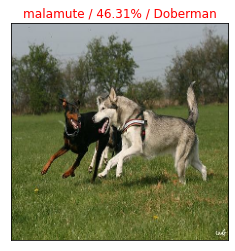

In [37]:
plot_pred(preds,unbatched_label,unbatched_image, 1)

Truth Label =  Doberman


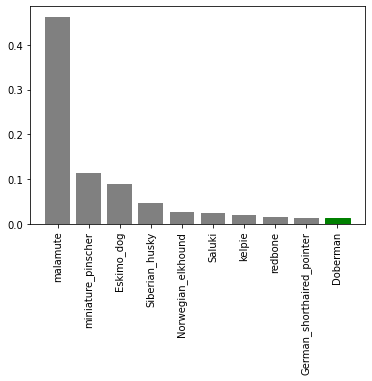

In [38]:
plot_pred_conf(preds, unbatched_label, 1)

## Reloading a trained model

In [39]:
# Create a function to load model
def load_model(model_path):
  """
  Loads a saved model from a specified path
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer" : hub.KerasLayer})
  return model

In [41]:
# Load a model trained on 1200 images
loaded_1200_image_model = load_model("Models/2022_08_13-07_19_1660375176-MobileNetV3_100_Adam_1200")

Loading saved model from: Models/2022_08_13-07_19_1660375176-MobileNetV3_100_Adam_1200


In [42]:
loaded_1200_image_model.evaluate(exp_val)

8/8 [==============================] - 1s 70ms/step - loss: 1.1682 - accuracy: 0.7125


[1.168182134628296, 0.7124999761581421]

# Training Model with Full Data
## NOW, lets train the mode with the full data (20580 images)

In [51]:
len(x_train), len(x_val), len(y_train), len(y_val)

(16464, 4116, 16464, 4116)

In [ ]:
# Create full model
full_model = train_model(train_data, val_data, "MobileNetV3_100_Adam_20580")

Building model with https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5


2022-08-13 07:59:59.111849: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-13 07:59:59.111909: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-13 07:59:59.274602: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-13 07:59:59.274811: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Model will be saved to `Models/2022_08_13-07_59_1660377599-MobileNetV3_100_Adam_20580`
Epoch 1/100
  1/515 [..............................] - ETA: 34:54 - loss: 5.3617 - accuracy: 0.0000e+00

2022-08-13 08:00:04.189154: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-13 08:00:04.189224: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/515 [..............................] - ETA: 8:10 - loss: 5.6079 - accuracy: 0.0000e+00 

2022-08-13 08:00:04.888623: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-13 08:00:04.889885: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-08-13 08:00:05.030397: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 425 callback api events and 422 activity events. 
2022-08-13 08:00:05.046681: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-13 08:00:05.065927: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: Logs/20220813-075959/train/plugins/profile/2022_08_13_08_00_05

2022-08-13 08:00:05.078846: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to Logs/20220813-075959/train/plugins/profile/2022_08_13_08_00_05/a085f1925c8c.trace.json.gz


  6/515 [..............................] - ETA: 3:03 - loss: 5.3645 - accuracy: 0.0208

2022-08-13 08:00:05.126888: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: Logs/20220813-075959/train/plugins/profile/2022_08_13_08_00_05

2022-08-13 08:00:05.135502: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to Logs/20220813-075959/train/plugins/profile/2022_08_13_08_00_05/a085f1925c8c.memory_profile.json.gz
2022-08-13 08:00:05.137677: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: Logs/20220813-075959/train/plugins/profile/2022_08_13_08_00_05
Dumped tool data for xplane.pb to Logs/20220813-075959/train/plugins/profile/2022_08_13_08_00_05/a085f1925c8c.xplane.pb
Dumped tool data for overview_page.pb to Logs/20220813-075959/train/plugins/profile/2022_08_13_08_00_05/a085f1925c8c.overview_page.pb
Dumped tool data for input_pipeline.pb to Logs/20220813-075959/train/plugins/profile/2022_08_13_08_00_05/a085f1925c8c.input_pipeline.pb
Dumped tool data for tens

 93/515 [====>.........................] - ETA: 35s - loss: 2.6725 - accuracy: 0.4375

Cleanup called...


515/515 [==============================] - 52s 94ms/step - loss: 1.0856 - accuracy: 0.7233 - val_loss: 0.5997 - val_accuracy: 0.8166
Epoch 2/100
514/515 [============================>.] - ETA: 0s - loss: 0.3657 - accuracy: 0.8839

Cleanup called...


515/515 [==============================] - 47s 90ms/step - loss: 0.3660 - accuracy: 0.8839 - val_loss: 0.5823 - val_accuracy: 0.8282
Epoch 3/100
119/515 [=====>........................] - ETA: 28s - loss: 0.2046 - accuracy: 0.9409

Cleanup called...


515/515 [==============================] - 46s 88ms/step - loss: 0.2254 - accuracy: 0.9314 - val_loss: 0.6054 - val_accuracy: 0.8217
Epoch 4/100
166/515 [========>.....................] - ETA: 25s - loss: 0.1384 - accuracy: 0.9633

Cleanup called...


515/515 [==============================] - 46s 89ms/step - loss: 0.1102 - accuracy: 0.9718 - val_loss: 0.6292 - val_accuracy: 0.8263
Epoch 6/100
 81/515 [===>..........................] - ETA: 34s - loss: 0.0732 - accuracy: 0.9853

Cleanup called...


515/515 [==============================] - 45s 87ms/step - loss: 0.0828 - accuracy: 0.9805 - val_loss: 0.6592 - val_accuracy: 0.8263
Epoch 7/100
295/515 [================>.............] - ETA: 15s - loss: 0.0613 - accuracy: 0.9874

Cleanup called...


515/515 [==============================] - 45s 87ms/step - loss: 0.0649 - accuracy: 0.9857 - val_loss: 0.6692 - val_accuracy: 0.8287
Epoch 8/100
 84/515 [===>..........................] - ETA: 29s - loss: 0.0437 - accuracy: 0.9940

Cleanup called...


515/515 [==============================] - 44s 86ms/step - loss: 0.0537 - accuracy: 0.9888 - val_loss: 0.6969 - val_accuracy: 0.8229
Epoch 9/100
312/515 [=================>............] - ETA: 14s - loss: 0.0396 - accuracy: 0.9933

Cleanup called...


515/515 [==============================] - 44s 86ms/step - loss: 0.0453 - accuracy: 0.9909 - val_loss: 0.7182 - val_accuracy: 0.8246
Epoch 10/100
 54/515 [==>...........................] - ETA: 31s - loss: 0.0378 - accuracy: 0.9907

Cleanup called...


515/515 [==============================] - 44s 86ms/step - loss: 0.0392 - accuracy: 0.9928 - val_loss: 0.7403 - val_accuracy: 0.8270
Epoch 11/100
170/515 [========>.....................] - ETA: 24s - loss: 0.0316 - accuracy: 0.9943

Cleanup called...


210/515 [===========>..................] - ETA: 21s - loss: 0.0319 - accuracy: 0.9940

In [ ]:
# Evaluate full model
full_model.evaluate(val_data, verbose=1)

## Testing the loaded full model on some custom images

In [ ]:
loaded_full_model = load_model("Models/2022:06:29-07:471656488859-full-image-set-mobilenetv2-Adam.h5")

In [ ]:
custom_images = [ "Images/custom-images/" + fname for fname in os.listdir("Images/custom-images")]
custom_images

In [ ]:
custom_batch = create_data_batches(custom_images, test_data=True)
custom_batch

In [ ]:
custom_predictions = loaded_full_model.predict(custom_batch)
custom_predictions

## Let's make a function to do 

In [ ]:
# COMPLETE DOG BREED PREDICTION FUNCTION
def dog_breed_predict(filename_list: list, model):
  # Turn images into batch datasets
  file_batch = create_data_batches(filename_list, test_data=True)
  # Make predictions on the data
  prediction = model.predict(file_batch)
  # Get custom image prediction labels
  custom_pred_labels = [get_pred_label(i) for i in prediction]
  # Unbatch batched datasets
  custom_images = []
  for image in file_batch.unbatch().as_numpy_iterator():
    custom_images.append(image)
  # Plot results
  no_rows = len(filename_list)//3 + (0 if (len(filename_list)%3 == 0) else 1)
  no_cols = 3
  if len(filename_list) < 3:
    no_cols = len(filename_list) * 3

  plt.figure(figsize=(3*no_cols,3*no_rows))
  for i, image in enumerate(custom_images):
    # Confidence percentage
    confidence_perc = np.max(prediction[i])*100

    # Coloring based on confidence
    if confidence_perc >= 85:
        color = "green"
    elif confidence_perc >= 70:
        color = "blue"
    elif confidence_perc >= 50:
        color = "orange"
    else:
        color = "red"
       
    plt.subplot(no_rows,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title("{} / {:2.2f}%".format(custom_pred_labels[i], confidence_perc), color=color)
    plt.imshow(image)

In [ ]:
dog_breed_predict(custom_images, loaded_full_model)

In [ ]:
idx = custom_predictions[1].argsort()[-10:][::-1]
for i in idx:
  print((unique_breeds[i] , f"{custom_predictions[1][i]*100} %"))

# Data Augmentation for further improvement on model (Enrichment of training data)

In [ ]:
def augment_image(image, seed):
  data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical",seed=seed),
    tf.keras.layers.RandomRotation(0.2,seed=seed),
    tf.keras.layers.RandomZoom(0.2,seed=seed),
    tf.keras.layers.RandomCrop(height=IMG_SIZE, width=IMG_SIZE,seed=seed),
    tf.keras.layers.RandomContrast(0.25,seed=seed)
  ])
  return data_augmentation(image)
  
# Show example of augmentations
image = process_image(custom_images[1])
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

plt.figure(figsize=(10, 8))
for i in range(9):
  augmented_image = augment_image(image, i)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [ ]:
# Lets create a function that augments the data when creating a tuple (image, label)
def get_augmented_image_tuple(filename, label, seed=0):
  """
  Takes an image file path and label
  then processes & augments and return a tuple (image, label)
  """
  image = process_image(filename)
  return augment_image(image, seed), label

In [ ]:
# Lets update the batching function
BATCH_SIZE = 32

#function to turn data to batches
def create_data_batches(x, y=None, batch_size=32, valid_data=False, test_data=False, augment=False, seed=0):
  """
  Create batches of data out of (image x) and (label y) pairs.
  Shuffles the data if its training data, but not when validation data.
  Also accepts test data as input (no labels).
  """
  #If test dataset, we probably don't have labels
  if test_data:
    print(f"Creating test data batches... BATCH SIZE={batch_size}")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(x))
    data_batch = data.map(process_image).batch(batch_size)

  #If validation dataset, we don't need to shuffle
  elif valid_data:
    print(f"Creating validation data batches... BATCH SIZE={batch_size}")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), #filepath
                                              tf.constant(y))) # labels
    if augment:
      print(f"Augmenting seed = {seed}")
      data = data.map(lambda data, seed : get_augmented_image_tuple(data, seed))
    else:
      data = data.map(get_image_tuple)
    data_batch = data.batch(batch_size)
  
  else:
    print(f"Creating training data batches... BATCH SIZE={batch_size}")
    #turn filepath and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), #filepath
                                              tf.constant(y))) # labels
    #shuffle
    data = data.shuffle(buffer_size=len(x))

    #process into (image,label) tuple and make batch
    if augment:
      print(f"Augmenting seed = {seed}")
      data = data.map(lambda data, seed : get_augmented_image_tuple(data, seed))
    else:
      data = data.map(get_image_tuple)
    data_batch = data.batch(batch_size)
  return data_batch

In [ ]:
#Create function for viewing images in data batches

def show_32_images(images, labels):
  """
  Display a plot of 25 images and their labels from data batch
  """
  plt.figure(figsize=(10,16))
  for i in range(32):
    #create subplots 4x8
    ax = plt.subplot(8,4, i+1)
    #Display Image
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    #remove axis
    plt.axis("off")

## First Iteration of Data Augmentation Training
Augment seed #0

In [ ]:
train_augment_batch = create_data_batches(x_train, y_train, augment=True, seed=0)
val_augment_batch = create_data_batches(x_val, y_val, valid_data=True, augment=True, seed=0)
train_augment_batch, val_augment_batch

In [ ]:
train_images, train_labels = next(train_augment_batch.as_numpy_iterator()) #This function unbatches it into a numpy array
len(train_images), len(train_labels) #shows shape 32,32 since its batch size is 32...

In [ ]:
show_32_images(train_images, train_labels)

### Now that we've augmented the dataset batches, let us incremently fit it into the previously trained model

In [ ]:
# Create full model callbacks
full_augment_model_tensorboard = create_tensorboard_callback()
full_augment_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3) # Stops when accuracy does not improve for 3 epochs

In [ ]:
# Fit the model to full data
loaded_full_model.fit(x=train_augment_batch,
                epochs=100,
                validation_data=val_augment_batch,
                validation_freq=1,
                callbacks=[full_augment_model_tensorboard, full_augment_model_early_stopping]
                )

In [ ]:
save_model(loaded_full_model, suffix="full-augment0-image-set-mobilenetv2-Adam")

In [ ]:
load_augment_model = load_model("Models/2022:06:29-08:541656492878-full-augment0-image-set-mobilenetv2-Adam.h5")

In [ ]:
dog_breed_predict(custom_images, load_augment_model)

In [ ]:
load_augment_model.evaluate(val_batch)

In [ ]:
load_augment_model.evaluate(val_augment_batch)

In [ ]:
loaded_full_model.evaluate(val_batch)

In [ ]:
loaded_full_model.evaluate(val_augment_batch)

### Evaluation after 1st iteration of augmented data fitting
As seen above, the accuracy of the `load_augment_model` has a slightly worse accuracy than the `loaded_full_model` when evaluating the normal validation data batches. BUT it performs **WAY BETTER** than the latter when evaluating the augmented validation data batches.

> This shows improvement in terms of the `model's overall scope` because it is generally performing better for all types of images (both normal and augmented)

**Note:**
 Realistically, people do not always has perfect images of dogs, so our model needs to be able to predict images that may be slightly augmented (translated, rotated, brightness, contrast, cropped, etc)

## Second Iteration of Data Augmentation Training
Augment seed #1

In [ ]:
# THEN WE AUGMENT IT AGAIN...
train_augment1_batch = create_data_batches(x_train, y_train, augment=True, seed=1)
val_augment1_batch = create_data_batches(x_val, y_val, valid_data=True, augment=True, seed=1)
train_augment1_batch, val_augment1_batch

In [ ]:
train_images, train_labels = next(train_augment1_batch.as_numpy_iterator()) #This function unbatches it into a numpy array
show_32_images(train_images, train_labels)

### Now that we've got our 2nd augmented data, lets fit it again

In [ ]:
load_augment_model = load_model("Models/2022_06_29-08_541656492878-full-augment0-image-set-mobilenetv2-Adam.h5")

In [ ]:
# Create full model callbacks
full_augment1_model_tensorboard = create_tensorboard_callback()
full_augment1_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3) # Stops when accuracy does not improve for 3 epochs

In [ ]:
# Fit the model to full data
load_augment_model.fit(x=train_augment1_batch,
                epochs=100,
                validation_data=val_augment1_batch,
                validation_freq=1,
                callbacks=[full_augment1_model_tensorboard, full_augment1_model_early_stopping]
                )

In [ ]:
saved_path = save_model(load_augment_model, suffix="full-augment1-image-set-mobilenetv2-Adam")

In [ ]:
from google.colab import files
files.download(saved_path)

In [ ]:
augment1_model = load_model("Models/2022:06:30-05:151656566150-full-augment1-image-set-mobilenetv2-Adam.h5")

In [ ]:
dog_breed_predict(custom_images, augment1_model)

In [ ]:
def evaluate_model(model_before, model_after, normal_batch, augment_batch):
  """
  Evaluates model and compare it with the previous model
  """
  print("NORMAL BATCH EVALUATION")
  print("Previous Model:")
  model_before.evaluate(normal_batch)
  print("New Model:")
  model_after.evaluate(normal_batch)
  print("\nAUGMENTED BATCH EVALUATION")
  print("Previous Model:")
  model_before.evaluate(augment_batch)
  print("New Model:")
  model_after.evaluate(augment_batch)

In [ ]:
evaluate_model(load_augment_model, augment1_model, val_batch, val_augment1_batch)

### Evaluation after 2nd iteration of augmented data fitting
As seen above, the model's accuracy on normal batch is yet again decreasing, but this time it shows worse accuracy on the augmented batch.
For the reason stated, we will be continuing with the previous model

## Third Iteration of Data Augmentation Training
Augment seed #2

In [ ]:
train_augment2_batch = create_data_batches(x_train, y_train, augment=True, seed=2)
val_augment2_batch = create_data_batches(x_val, y_val, valid_data=True, augment=True, seed=2)
train_augment2_batch, val_augment_batch

In [ ]:
train_images, train_labels = next(train_augment2_batch.as_numpy_iterator()) #This function unbatches it into a numpy array
len(train_images), len(train_labels) #shows shape 32,32 since its batch size is 32...

In [ ]:
show_32_images(train_images, train_labels)

### Augmented Data Fitting

In [ ]:
loaded_model = load_model("Models/2022_06_29-08_541656492878-full-augment0-image-set-mobilenetv2-Adam.h5")

In [ ]:
# Create full model callbacks
full_augment2_model_tensorboard = create_tensorboard_callback()
full_augment2_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3) # Stops when accuracy does not improve for 3 epochs

In [ ]:
# Fit the model to full data
loaded_model.fit(x=train_augment2_batch,
                epochs=100,
                validation_data=val_augment2_batch,
                validation_freq=1,
                callbacks=[full_augment2_model_tensorboard, full_augment2_model_early_stopping]
                )

In [ ]:
saved_path = save_model(loaded_model, suffix="full-augment2-image-set-mobilenetv2-Adam")

In [ ]:
loaded_augment2 = load_model(saved_path)

In [ ]:
dog_breed_predict(custom_images, loaded_augment2)

In [ ]:
prev_model = load_model("/content/Models/2022_06_29-08_541656492878-full-augment0-image-set-mobilenetv2-Adam.h5")

In [ ]:
evaluate_model(prev_model, loaded_augment2, val_batch, val_augment2_batch)

### Evaluation after 3rd iteration of augmented data fitting
As seen above, the model's accuracy on normal batch is yet again decreasing, but this time it shows worse accuracy on the augmented batch.
For the reason stated, we will be continuing with the previous model

## 3rd Iteration of Augmented Data Training
Augment seed #3

In [ ]:
def augment_training(prev_model_path, seed, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, custom_images=custom_images, val_batch=val_batch):
  """
  Function for the entire Iteration of Augmented data training
  """
  # Augmentation
  train_augment_batch = create_data_batches(x_train, y_train, augment=True, seed=seed)
  val_augment_batch = create_data_batches(x_val, y_val, valid_data=True, augment=True, seed=seed)

  # Training prep
  model = load_model(prev_model_path)
  full_augment_model_tensorboard = create_tensorboard_callback()
  full_augment_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3) # Stops when accuracy does not improve for 3 epochs
  
  # Fit the model to full data
  loaded_model.fit(x=train_augment_batch,
                epochs=100,
                validation_data=val_augment_batch,
                validation_freq=1,
                callbacks=[full_augment_model_tensorboard, full_augment_model_early_stopping]
                )
  saved_path = save_model(loaded_model, suffix=f"full-augment{seed}-image-set-mobilenetv2-Adam")
  
  # Evaluation
  prev_model = load_model(prev_model_path)
  dog_breed_predict(custom_images, loaded_model)
  evaluate_model(prev_model, loaded_model, val_batch, val_augment_batch)

In [ ]:
augment_training("Models/2022_06_29-08_541656492878-full-augment0-image-set-mobilenetv2-Adam.h5", 3)

In [ ]:
augment_training("Models/2022:06:30-07:121656573132-full-augment3-image-set-mobilenetv2-Adam.h5", 4)

In [ ]:
!zip -r Logs.zip Logs

In [ ]:
augment_training("/content/Models/2022:06:30-07:451656575156-full-augment4-image-set-mobilenetv2-Adam.h5", 5)

In [ ]:
augment_training("/content/Models/2022:06:30-08:221656577369-full-augment5-image-set-mobilenetv2-Adam.h5", 6)

In [ ]:
augment_training("/content/Models/2022_06_30-08_48_1656578928-full-augment6-image-set-mobilenetv2-Adam.h5", 7)

In [ ]:
augment_training("Models/2022_06_30-09_27_1656581275-full-augment7-image-set-mobilenetv2-Adam.h5", 8)

In [ ]:
!zip -r Models.zip Models

In [ ]:
!zip -r Logs.zip Logs

In [ ]:
augment_training("Models/2022_06_30-09_54_1656582840-full-augment8-image-set-mobilenetv2-Adam.h5", 9)